<a href="https://colab.research.google.com/github/nmningmei/Deep_learning_fMRI_EEG/blob/master/6_1_C_RNN_decoding_models_of_EEG_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Something you have to do everytime you use colab and the data are in your google drive

In [0]:
!pip install -U mne

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 6.3MB 671kB/s 
  Stored in directory: /root/.cache/pip/wheels/71/40/30/fb9a9bdeac02c6b3b144be66ac345c5b5587a7d7610564535b
Successfully built mne
     |████████████████████████████████| 993kB 45.3MB/s 


In [0]:
epochs_id = 'https://drive.google.com/open?id=1u6E5PFfdIbrqMM2y0mljqxUlZRjr_Jc5'.split('id=')[-1]
downloaded = drive.CreateFile({'id':epochs_id})
downloaded.GetContentFile(f'epochs-epo.fif')

# let's look at the data first

In [0]:
import mne
import pandas as pd
import numpy as np

In [0]:
epochs = mne.read_epochs('epochs-epo.fif',preload = True)

Reading epochs-epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
1728 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated


## get the unique events and its event ids

In [0]:
epochs.event_id

{'living living conscious': 248,
 'living living glimpse': 247,
 'living living unconscious': 246,
 'living nonliving conscious': 258,
 'living nonliving glimpse': 257,
 'living nonliving unconscious': 256,
 'nonliving living conscious': 348,
 'nonliving living glimpse': 347,
 'nonliving living unconscious': 346,
 'nonliving nonliving conscious': 358,
 'nonliving nonliving glimpse': 357,
 'nonliving nonliving unconscious': 356}

## get the onset time of the event and its event ids

In [0]:
epochs.events

array([[   2684,       0,     348],
       [   7424,       0,     257],
       [  12986,       0,     358],
       ...,
       [7612747,       0,     256],
       [7616325,       0,     347],
       [7621346,       0,     347]])

In [0]:
conscious   = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if (' conscious' in name)])
glimpse     = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if ('glimpse' in name)])
unconscious = mne.concatenate_epochs([epochs[name] for name in epochs.event_id.keys() if ('unconscious' in name)])
del epochs

532 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
570 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
626 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


### right click on the grey bar of the code cell and you can view the outputs in full screen

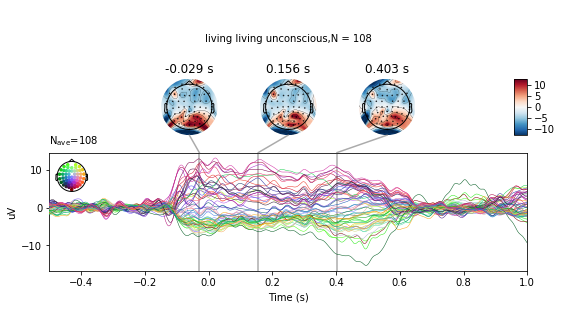

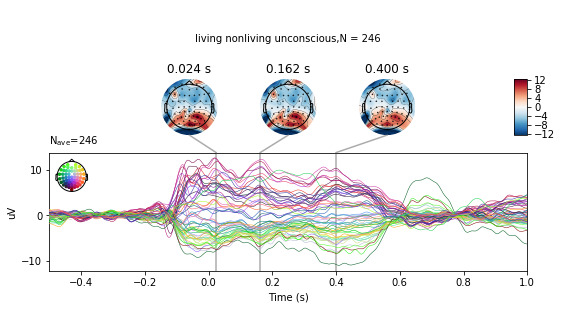

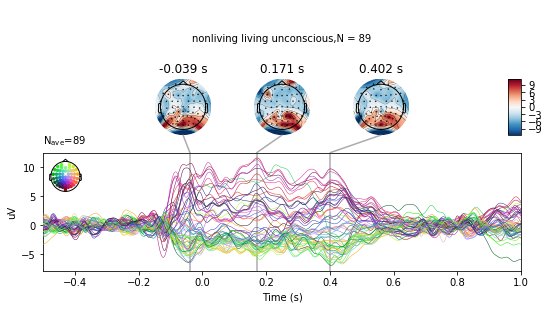

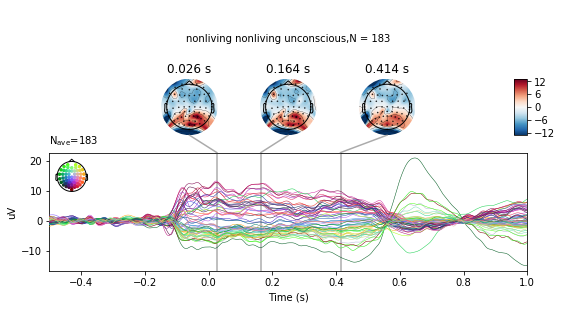

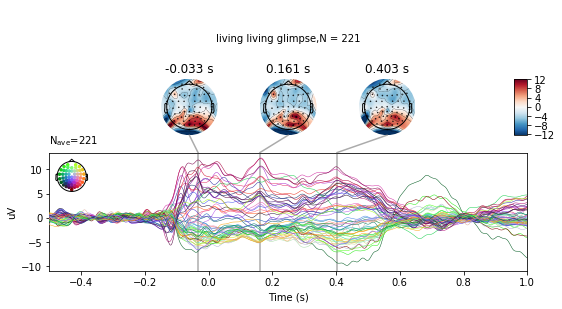

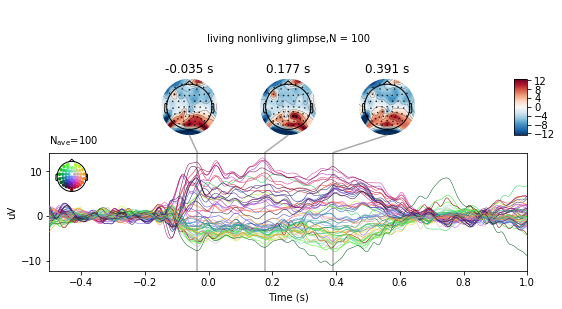

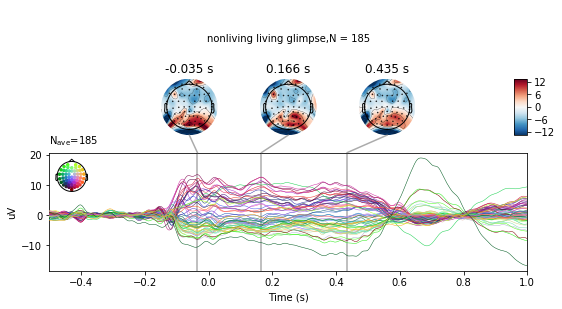

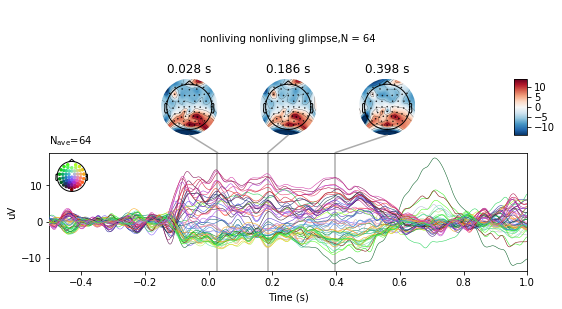

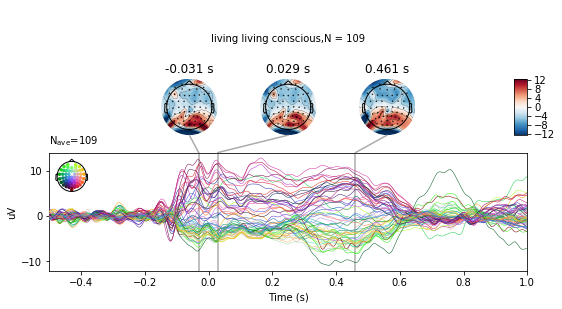

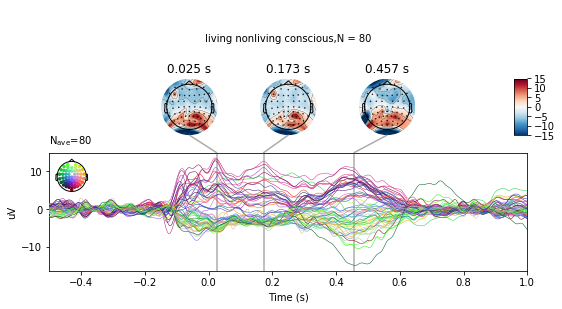

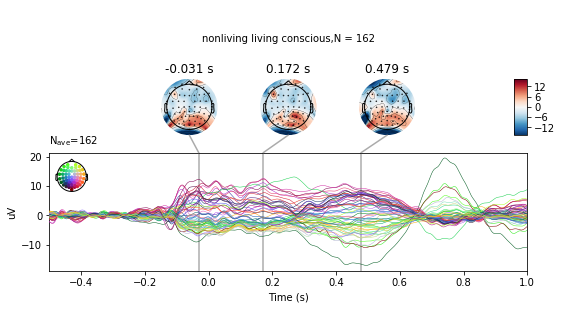

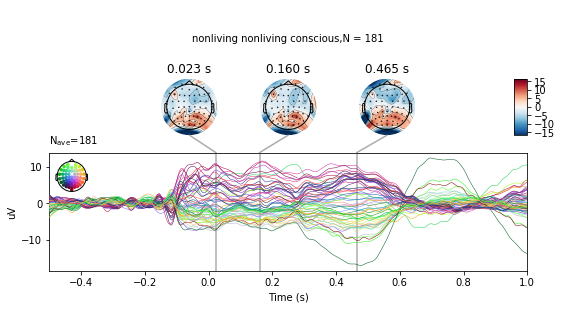

In [0]:
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    for unique_id in list(epochs.event_id.keys()):
        epochs[unique_id].average().plot_joint(title = f"{unique_id},N = {epochs[unique_id].get_data().shape[0]}")
    

## set up a baseline model - logistic regression

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.utils import shuffle
from mne.decoding import Scaler,Vectorizer

n_splits = 10
n_jobs = -1
logistic = LogisticRegression(
                              solver        = 'lbfgs',
                              max_iter      = int(1e3),
                              random_state  = 12345,
                              class_weight  = 'balanced'
                              )

In [0]:
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    epochs.resample(100) # to speed things up
    # define a cross validation method
    cv          = StratifiedShuffleSplit(
                             n_splits       = n_splits, 
                             test_size      = 0.1, 
                             random_state   = 12345)
    # define a pipeline in which all data would have the same procedure steps
    pipeline    = make_pipeline(
                             Vectorizer(),
                             StandardScaler(),
                             clone(logistic),
                             )
    # get the data and convert them into numpy arrays
    X,y = epochs.get_data(),epochs.events[:,-1]
    # binarize the target labels
    y = y //100 - 2
    
    # shuffle the order of trials
    np.random.seed(12345)
    X,y = shuffle(X,y)
    # black box machine learning because all we care is the cross validation performance
    scores      = cross_val_score(
                             pipeline,
                             X,
                             y,
                             scoring         = 'roc_auc',
                             cv              = cv,
                             n_jobs          = n_jobs,
                             )
    plscores = scores.copy()
    print(f'decode {conscious_state} (N = {X.shape[0]}) = {plscores.mean():.4f}+/-{plscores.std():.4f}')

decode unconscious (N = 626) = 0.4751+/-0.0591
decode glimpse (N = 570) = 0.5329+/-0.0523
decode conscious (N = 532) = 0.5662+/-0.0440


## RNN classifier (n_parameters = 589)

### Architecture:

Since the data is (n_samples x n_channels x n_time_steps), we can pass the time steps to a RNN layer that contains the same number of RNN neurons as the time step, so that each neuron would take the input of the time step and the previous neuron. And then pass the output of this RNN to another RNN, and then classify the targets based on the last RNN outputs. 

### RNN layer - Gated Recurrent Unit -- GRU

This is chosen because its simplicity compared to LSTM. 

**LSTM**

![LSTM](https://cdn-images-1.medium.com/max/800/1*goJVQs-p9kgLODFNyhl9zA.gif)

**GRU**

![GRU](https://cdn-images-1.medium.com/max/800/1*FpRS0C3EHQnELVaWRvb8bg.gif)

source: [Animated RNN, LSTM and GRU](https://towardsdatascience.com/animated-rnn-lstm-and-gru-ef124d06cf45)

### helper funtion

In [0]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras import layers,Model, optimizers,losses,regularizers#,Sequential
from keras import metrics as k_metrics
import keras.backend as K

Using TensorFlow backend.


In [0]:
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    from keras.callbacks import ModelCheckpoint,EarlyStopping
    """
    Make call back function lists for the keras models
    
    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor: the criterion we used for saving or stopping the model
    mode: min --> lower the better, max --> higher the better
    verboser: printout the monitoring messages
    min_delta: minimum change for early stopping
    patience: temporal windows of the minimum change monitoring
    frequency: temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint: saving the best model
    EarlyStopping: early stoppi....
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          = monitor,# saving criterion
                                 save_best_only   = True,# save only the best model
                                 mode             = mode,# saving criterion
                                 period           = frequency,# frequency of check the update 
                                 verbose          = verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          = monitor,
                                 min_delta        = min_delta,
                                 patience         = patience,
                                 verbose          = verbose, 
                                 mode             = mode,
                                 )
    return [checkPoint,earlyStop]
def preprocess_features(X,vectorizer = None,scaler = None):
    from sklearn.preprocessing import MinMaxScaler
    if vectorizer is None:
        vectorizer          = mne.decoding.Vectorizer()
        X_vec               = vectorizer.fit_transform(X)
    else:
        X_vec               = vectorizer.transform(X)
    if scaler is None:
        scaler              = MinMaxScaler()
        X_vec_standard      = scaler.fit_transform(X_vec)
    else:
        X_vec_standard      = scaler.transform(X_vec)
    X_vec_tran          = vectorizer.inverse_transform(X_vec_standard)
    
    return X_vec_tran,vectorizer,scaler

def build_model(timesteps,data_dim,n_units = 1,batch_size = 10,n_layers = 3,drop = True):
    K.clear_session()
    inputs      = layers.Input(
                       shape = (timesteps,data_dim,),
                       batch_shape = (batch_size,timesteps,data_dim),
                       name = 'inputs')
    inputs_ = inputs
    RNN,state_h = layers.GRU(units = n_units,
                              return_state = True,
                              return_sequences = True,
                              name = 'rnn{}'.format(1))(inputs_)
    for n_temp in range(n_layers - 1):
        RNN,state_h = layers.GRU(units = n_units,
                                  return_state = True,
                                  return_sequences = True,
                                  dropout = 0.25,
                                  recurrent_dropout = 0.25,
                                  name = 'rnn{}'.format(n_temp + 2))(RNN,initial_state = [state_h])
        if drop:
            RNN = layers.Dropout(0.25,name = 'drop{}'.format(n_temp + 1))(RNN)
    RNN = layers.Lambda(lambda x: K.squeeze(x,-1))(RNN)
    outputs = layers.Dense(2,activation = 'softmax',
                           activity_regularizer = regularizers.l1(1),
                           name = 'outputs',)(RNN)
    classifier = Model(inputs,outputs,name = 'clf')
    return classifier

In [0]:
n_splits = 5
n_epochs = int(40)
results = []
print_model = True
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    epochs.resample(100) # to speed things up
    epochs = epochs.pick_types(eeg=True)
    
    # try not to touch the raw epochs
    X_,y_               = epochs.get_data(),epochs.events[:,-1]
    # binarize the target labels
    y_                  = y_ //100 - 2

    # prepare the numpy array for the features (epochs n_samples X n_channels X n_timesteps) and target labels (living vs nonliving) 
    X,targets           = X_.copy(),y_.copy()
    # make target labels [0,1](living) or [1,0](nonliving)
    targets             = np.vstack([targets,1-targets]).T
    # scale the features to a reasonable range == *1e6
    X                   = mne.decoding.Scaler(epochs.info).fit_transform(X)
    # sine RNNs takes input in the format of n_samples X n_timesteps X n_channels, we swap the axes
    X                   = np.swapaxes(X,1,2)
    ss                  = [] # preallocate
    # define a cross validation method to split train and test data
    cv                  = StratifiedShuffleSplit(n_splits=n_splits,test_size = 0.15,random_state=12345)
    for fold,(idx_,idx_test) in enumerate(cv.split(X,targets)):
        # within the train data, we split it into training and validating dataset
        X_train,X_valid,y_train,y_valid = train_test_split(
                X[idx_],targets[idx_],
                test_size               = 0.15,
                random_state            = 12345,
                shuffle                 = True,)
        # some preprocessing to make RNNs happier
        X_train,vectorizer,scaler = preprocess_features(X_train)
        # apply the fit preprocessing steps to the validation data
        X_valid,_,_ = preprocess_features(X_valid,vectorizer,scaler)

        # all the hyperparameters that I know what to with
        model_name  = 'RNN.hdf5'
        batch_size  = 10
        timesteps   = X.shape[1]
        data_dim    = X.shape[2]
        n_units     = 1
        n_layers    = 2
        dropout     = True
        
        # only make sense if we actually use tensorflow or pytorch
        remain_train = X_train.shape[0] % batch_size
        remain_valid = X_valid.shape[0] % batch_size

        if remain_train != 0:
            np.random.seed(12345)
            idx_train = np.random.choice(X_train.shape[0],size = X_train.shape[0] - remain_train)
            X_train,y_train = X_train[idx_train],y_train[idx_train]

        if remain_valid != 0:
            np.random.seed(12345)
            idx_valid = np.random.choice(X_valid.shape[0],size = X_valid.shape[0] - remain_valid)
            X_valid,y_valid = X_valid[idx_valid],y_valid[idx_valid]
        
        # manually balance the loss function for the 2 classes
        # unlike in scikitlearn, you can just define "balanced" in the classifier
        from collections import Counter
        class_weight = dict(Counter(y_train[:,0]))
        class_weight = {key:(y_train.shape[0] - value)/value for key,value in class_weight.items()}
        print(class_weight)
        sample_weight = [class_weight[item] for item in y_train[:,0]]
        
        # build the RNN classifier
        classifier = build_model(timesteps=timesteps,
                                 data_dim=data_dim,
                                 n_units=n_units,
                                 batch_size=batch_size,
                                 n_layers = n_layers,
                                 drop=dropout)
        print(f'the model has {classifier.count_params()} parameters')
        if print_model:
            classifier.summary()
            print_model = False
        
        # don't forget to compile the optimizer and loss function before fitting
        classifier.compile(optimizer                = optimizers.Adam(lr = 1e-4),
                           loss                     = losses.categorical_crossentropy,
                           metrics                  = [k_metrics.categorical_accuracy])
        # define an early stoping criterion
        temp = [1,5]
        def call_back_dict(care = 'loss'):
            if care == 'loss':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[0]),
                        mode = 'min',
                        patience = 4,
                        min_delta = 1e-1)
            elif care == 'metric':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[-1]),
                        mode = 'max',
                        patience = 4,
                        min_delta = 1e-4)
            else:
                print('why?')
        callBackList = make_CallBackList(
               model_name,
               verbose          = 0,# print out the process
               frequency        = 1,
               **call_back_dict('metric')
               )
        # shuffle the training data again
        np.random.seed(12345)
        X_train,y_train = shuffle(X_train,y_train)
        # fit
        classifier.fit(X_train,y_train,
                       batch_size               = batch_size,
                       epochs                   = n_epochs,
                       validation_data          = (X_valid,y_valid),
                       callbacks                = callBackList,
                       shuffle                  = True,
                       sample_weight            = np.array(sample_weight), # this is the key !
                       )

        # if an early stopping is setup, don't forget to load the best set of weights that was selected
        # by the early stopping
        classifier.load_weights(model_name)

        # apply the fit preprocessing steps to the test data
        X_test,_,_ = preprocess_features(X[idx_test],vectorizer,scaler)
        remain_test = X_test.shape[0] % batch_size
        if remain_test != 0:
            X_test,y_test = X_test[:-remain_test],targets[idx_test][:-remain_test]
        else:
            y_test = targets[idx_test]


        preds = classifier.predict(X_test,batch_size=batch_size,verbose = 0)

        ss.append(metrics.roc_auc_score(y_test,
                                        preds))
        print(f'{conscious_state},fold {fold+1},{ss[-1]:.4f}')
        K.clear_session()
    results.append([conscious_state,ss])
print([np.mean(item[1]) for item in results])

W0707 11:29:31.502121 140140038821760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0707 11:29:31.503337 140140038821760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0707 11:29:31.533306 140140038821760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 11:29:31.534284 140140038821760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W070

{0: 0.7509727626459144, 1: 1.3316062176165804}


W0707 11:29:31.749592 140140038821760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0707 11:29:31.997853 140140038821760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0707 11:29:32.156992 140140038821760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


the model has 497 parameters
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (10, 150, 60)        0                                            
__________________________________________________________________________________________________
rnn1 (GRU)                      [(10, 150, 1), (10,  186         inputs[0][0]                     
__________________________________________________________________________________________________
rnn2 (GRU)                      [(10, 150, 1), (10,  9           rnn1[0][0]                       
                                                                 rnn1[0][1]                       
__________________________________________________________________________________________________
drop1 (Dropout)                 (10, 150, 1)         0           rnn2[0][0]     

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


450/450 [==============================] - 14s 31ms/step - loss: 10.8127 - categorical_accuracy: 0.4978 - val_loss: 10.8220 - val_categorical_accuracy: 0.3625
Epoch 3/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7666 - categorical_accuracy: 0.4911 - val_loss: 10.7733 - val_categorical_accuracy: 0.3625
Epoch 4/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7383 - categorical_accuracy: 0.4689 - val_loss: 10.7455 - val_categorical_accuracy: 0.4000
Epoch 5/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7159 - categorical_accuracy: 0.5089 - val_loss: 10.7222 - val_categorical_accuracy: 0.4000
Epoch 6/40
450/450 [==============================] - 14s 31ms/step - loss: 10.6986 - categorical_accuracy: 0.5600 - val_loss: 10.7084 - val_categorical_accuracy: 0.4375
Epoch 7/40
450/450 [==============================] - 14s 30ms/step - loss: 10.7049 - categorical_accuracy: 0.5244 - val_loss: 10.6967 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


450/450 [==============================] - 14s 32ms/step - loss: 10.8287 - categorical_accuracy: 0.4978 - val_loss: 10.8342 - val_categorical_accuracy: 0.3750
Epoch 3/40
450/450 [==============================] - 14s 32ms/step - loss: 10.7890 - categorical_accuracy: 0.4622 - val_loss: 10.7785 - val_categorical_accuracy: 0.3875
Epoch 4/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7203 - categorical_accuracy: 0.5067 - val_loss: 10.7569 - val_categorical_accuracy: 0.3875
Epoch 5/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7196 - categorical_accuracy: 0.4778 - val_loss: 10.7390 - val_categorical_accuracy: 0.3750
Epoch 6/40
450/450 [==============================] - 14s 32ms/step - loss: 10.7032 - categorical_accuracy: 0.5267 - val_loss: 10.7267 - val_categorical_accuracy: 0.3875
Epoch 7/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7008 - categorical_accuracy: 0.5178 - val_loss: 10.7137 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


450/450 [==============================] - 14s 31ms/step - loss: 10.8377 - categorical_accuracy: 0.4689 - val_loss: 10.7980 - val_categorical_accuracy: 0.3875
Epoch 3/40
450/450 [==============================] - 15s 33ms/step - loss: 10.7815 - categorical_accuracy: 0.4867 - val_loss: 10.7515 - val_categorical_accuracy: 0.4000
Epoch 4/40
450/450 [==============================] - 14s 32ms/step - loss: 10.7380 - categorical_accuracy: 0.4956 - val_loss: 10.7267 - val_categorical_accuracy: 0.4250
Epoch 5/40
450/450 [==============================] - 15s 32ms/step - loss: 10.7189 - categorical_accuracy: 0.5289 - val_loss: 10.7138 - val_categorical_accuracy: 0.4750
Epoch 6/40
450/450 [==============================] - 15s 33ms/step - loss: 10.7068 - categorical_accuracy: 0.5156 - val_loss: 10.7027 - val_categorical_accuracy: 0.5250
Epoch 7/40
450/450 [==============================] - 14s 32ms/step - loss: 10.6964 - categorical_accuracy: 0.5378 - val_loss: 10.6923 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


450/450 [==============================] - 14s 31ms/step - loss: 10.8158 - categorical_accuracy: 0.4756 - val_loss: 10.7820 - val_categorical_accuracy: 0.4250
Epoch 3/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7552 - categorical_accuracy: 0.5044 - val_loss: 10.7472 - val_categorical_accuracy: 0.4125
Epoch 4/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7296 - categorical_accuracy: 0.5133 - val_loss: 10.7292 - val_categorical_accuracy: 0.4500
Epoch 5/40
450/450 [==============================] - 14s 32ms/step - loss: 10.7148 - categorical_accuracy: 0.5111 - val_loss: 10.7147 - val_categorical_accuracy: 0.4500
Epoch 6/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7125 - categorical_accuracy: 0.4733 - val_loss: 10.7048 - val_categorical_accuracy: 0.4750
Epoch 7/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7058 - categorical_accuracy: 0.5022 - val_loss: 10.6984 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


450/450 [==============================] - 14s 31ms/step - loss: 10.8617 - categorical_accuracy: 0.4400 - val_loss: 10.7987 - val_categorical_accuracy: 0.4000
Epoch 3/40
450/450 [==============================] - 14s 32ms/step - loss: 10.7671 - categorical_accuracy: 0.4933 - val_loss: 10.7631 - val_categorical_accuracy: 0.4125
Epoch 4/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7352 - categorical_accuracy: 0.4778 - val_loss: 10.7447 - val_categorical_accuracy: 0.4125
Epoch 5/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7288 - categorical_accuracy: 0.4933 - val_loss: 10.7283 - val_categorical_accuracy: 0.4250
Epoch 6/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7034 - categorical_accuracy: 0.5178 - val_loss: 10.7194 - val_categorical_accuracy: 0.4000
Epoch 7/40
450/450 [==============================] - 14s 31ms/step - loss: 10.7033 - categorical_accuracy: 0.4978 - val_loss: 10.7092 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6828 - categorical_accuracy: 0.5610 - val_loss: 10.6917 - val_categorical_accuracy: 0.5286
Epoch 3/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6911 - categorical_accuracy: 0.5537 - val_loss: 10.6924 - val_categorical_accuracy: 0.5286
Epoch 4/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6865 - categorical_accuracy: 0.5415 - val_loss: 10.6929 - val_categorical_accuracy: 0.5286
Epoch 5/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6900 - categorical_accuracy: 0.5390 - val_loss: 10.6934 - val_categorical_accuracy: 0.5286
glimpse,fold 1,0.4729
{0: 0.7012448132780082, 1: 1.4260355029585798}
the model has 497 parameters
Train on 410 samples, validate on 70 samples
Epoch 1/40
410/410 [==============================] - 14s 34ms/step - loss: 10.6876 - categorical_accuracy: 0.5366 - val_loss: 10.6822 - val_categorical_accuracy: 0.5857


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6863 - categorical_accuracy: 0.5512 - val_loss: 10.6791 - val_categorical_accuracy: 0.5857
Epoch 3/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6853 - categorical_accuracy: 0.5659 - val_loss: 10.6784 - val_categorical_accuracy: 0.5857
Epoch 4/40
410/410 [==============================] - 13s 31ms/step - loss: 10.7026 - categorical_accuracy: 0.5439 - val_loss: 10.6793 - val_categorical_accuracy: 0.5857
Epoch 5/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6777 - categorical_accuracy: 0.6024 - val_loss: 10.6788 - val_categorical_accuracy: 0.5857
glimpse,fold 2,0.4178
{0: 0.8222222222222222, 1: 1.2162162162162162}
the model has 497 parameters
Train on 410 samples, validate on 70 samples
Epoch 1/40
410/410 [==============================] - 14s 34ms/step - loss: 10.7025 - categorical_accuracy: 0.4805 - val_loss: 10.6769 - val_categorical_accuracy: 0.6571
Epoch 2

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


410/410 [==============================] - 13s 31ms/step - loss: 10.7008 - categorical_accuracy: 0.4805 - val_loss: 10.6723 - val_categorical_accuracy: 0.6571
Epoch 3/40
410/410 [==============================] - 13s 31ms/step - loss: 10.7151 - categorical_accuracy: 0.4878 - val_loss: 10.6716 - val_categorical_accuracy: 0.6571
Epoch 4/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6991 - categorical_accuracy: 0.5049 - val_loss: 10.6727 - val_categorical_accuracy: 0.6571
Epoch 5/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6919 - categorical_accuracy: 0.5244 - val_loss: 10.6695 - val_categorical_accuracy: 0.6571
glimpse,fold 3,0.5366
{1: 1.1578947368421053, 0: 0.8636363636363636}
the model has 497 parameters
Train on 410 samples, validate on 70 samples
Epoch 1/40
410/410 [==============================] - 14s 34ms/step - loss: 10.6981 - categorical_accuracy: 0.5268 - val_loss: 10.6867 - val_categorical_accuracy: 0.5714


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
410/410 [==============================] - 13s 32ms/step - loss: 10.7035 - categorical_accuracy: 0.5122 - val_loss: 10.6855 - val_categorical_accuracy: 0.5714
Epoch 3/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6977 - categorical_accuracy: 0.4829 - val_loss: 10.6858 - val_categorical_accuracy: 0.5714
Epoch 4/40
410/410 [==============================] - 13s 32ms/step - loss: 10.6963 - categorical_accuracy: 0.5268 - val_loss: 10.6870 - val_categorical_accuracy: 0.5714
Epoch 5/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6905 - categorical_accuracy: 0.5317 - val_loss: 10.6856 - val_categorical_accuracy: 0.5714
glimpse,fold 4,0.4903
{0: 0.680327868852459, 1: 1.4698795180722892}
the model has 497 parameters
Train on 410 samples, validate on 70 samples
Epoch 1/40
410/410 [==============================] - 14s 33ms/step - loss: 10.6939 - categorical_accuracy: 0.5317 - val_loss: 10.6734 - val_categorical_accuracy: 0.6714


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6891 - categorical_accuracy: 0.5561 - val_loss: 10.6606 - val_categorical_accuracy: 0.6714
Epoch 3/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6809 - categorical_accuracy: 0.5585 - val_loss: 10.6550 - val_categorical_accuracy: 0.6714
Epoch 4/40
410/410 [==============================] - 13s 31ms/step - loss: 10.7003 - categorical_accuracy: 0.5537 - val_loss: 10.6539 - val_categorical_accuracy: 0.6714
Epoch 5/40
410/410 [==============================] - 13s 31ms/step - loss: 10.6879 - categorical_accuracy: 0.5463 - val_loss: 10.6540 - val_categorical_accuracy: 0.6714
glimpse,fold 5,0.4047
{0: 1.7941176470588236, 1: 0.5573770491803278}
the model has 497 parameters
Train on 380 samples, validate on 60 samples
Epoch 1/40
380/380 [==============================] - 13s 34ms/step - loss: 10.7175 - categorical_accuracy: 0.4289 - val_loss: 10.7017 - val_categorical_accuracy: 0.4500


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
380/380 [==============================] - 12s 32ms/step - loss: 10.6986 - categorical_accuracy: 0.5105 - val_loss: 10.6969 - val_categorical_accuracy: 0.3500
Epoch 3/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6931 - categorical_accuracy: 0.5211 - val_loss: 10.6940 - val_categorical_accuracy: 0.5500
Epoch 4/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6839 - categorical_accuracy: 0.6105 - val_loss: 10.6924 - val_categorical_accuracy: 0.5500
Epoch 5/40
380/380 [==============================] - 12s 32ms/step - loss: 10.6781 - categorical_accuracy: 0.5868 - val_loss: 10.6915 - val_categorical_accuracy: 0.5500
Epoch 6/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6701 - categorical_accuracy: 0.5895 - val_loss: 10.6913 - val_categorical_accuracy: 0.5500
Epoch 7/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6588 - categorical_accuracy: 0.6342 - val_loss: 10.6922 - val_categoric

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6932 - categorical_accuracy: 0.5079 - val_loss: 10.6926 - val_categorical_accuracy: 0.3833
Epoch 3/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6915 - categorical_accuracy: 0.5184 - val_loss: 10.6782 - val_categorical_accuracy: 0.7333
Epoch 4/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6894 - categorical_accuracy: 0.5842 - val_loss: 10.6648 - val_categorical_accuracy: 0.7333
Epoch 5/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6853 - categorical_accuracy: 0.6263 - val_loss: 10.6592 - val_categorical_accuracy: 0.7333
Epoch 6/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6724 - categorical_accuracy: 0.6421 - val_loss: 10.6484 - val_categorical_accuracy: 0.7333
Epoch 7/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6595 - categorical_accuracy: 0.6737 - val_loss: 10.6370 - val_categoric

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


380/380 [==============================] - 12s 30ms/step - loss: 10.7085 - categorical_accuracy: 0.4763 - val_loss: 10.6992 - val_categorical_accuracy: 0.3333
Epoch 3/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6978 - categorical_accuracy: 0.4947 - val_loss: 10.6854 - val_categorical_accuracy: 0.6833
Epoch 4/40
380/380 [==============================] - 12s 30ms/step - loss: 10.6869 - categorical_accuracy: 0.5500 - val_loss: 10.6726 - val_categorical_accuracy: 0.7333
Epoch 5/40
380/380 [==============================] - 12s 30ms/step - loss: 10.6799 - categorical_accuracy: 0.6079 - val_loss: 10.6647 - val_categorical_accuracy: 0.7333
Epoch 6/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6773 - categorical_accuracy: 0.6000 - val_loss: 10.6590 - val_categorical_accuracy: 0.7333
Epoch 7/40
380/380 [==============================] - 12s 30ms/step - loss: 10.6784 - categorical_accuracy: 0.6026 - val_loss: 10.6495 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


380/380 [==============================] - 12s 31ms/step - loss: 10.6977 - categorical_accuracy: 0.5132 - val_loss: 10.6868 - val_categorical_accuracy: 0.5833
Epoch 3/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6907 - categorical_accuracy: 0.5526 - val_loss: 10.6694 - val_categorical_accuracy: 0.8667
Epoch 4/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6830 - categorical_accuracy: 0.5763 - val_loss: 10.6544 - val_categorical_accuracy: 0.8333
Epoch 5/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6768 - categorical_accuracy: 0.6158 - val_loss: 10.6400 - val_categorical_accuracy: 0.8333
Epoch 6/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6664 - categorical_accuracy: 0.6237 - val_loss: 10.6196 - val_categorical_accuracy: 0.8333
Epoch 7/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6637 - categorical_accuracy: 0.6237 - val_loss: 10.6046 - val_categorical_accuracy

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/40
380/380 [==============================] - 12s 31ms/step - loss: 10.7027 - categorical_accuracy: 0.4632 - val_loss: 10.6961 - val_categorical_accuracy: 0.4500
Epoch 3/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6985 - categorical_accuracy: 0.5158 - val_loss: 10.6868 - val_categorical_accuracy: 0.6333
Epoch 4/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6890 - categorical_accuracy: 0.5658 - val_loss: 10.6802 - val_categorical_accuracy: 0.6500
Epoch 5/40
380/380 [==============================] - 12s 30ms/step - loss: 10.6841 - categorical_accuracy: 0.5579 - val_loss: 10.6764 - val_categorical_accuracy: 0.6500
Epoch 6/40
380/380 [==============================] - 12s 31ms/step - loss: 10.6810 - categorical_accuracy: 0.5658 - val_loss: 10.6728 - val_categorical_accuracy: 0.6500
Epoch 7/40
380/380 [==============================] - 12s 30ms/step - loss: 10.6708 - categorical_accuracy: 0.6237 - val_loss: 10.6683 - val_categoric

## CNN-RNN  classifier (n_parameters = 49,892)



### Architecture:

Since the data is (n_samples x n_channels x n_time_steps), we can perform a convolution on the time steps and then pass the convoled "features" to a RNN layer, which could speed up RNN processing, even though we have way more parameters. In this case, we will need more regularization to avoid overfitting. 


Nowadays, 1D convolutional layers are widely used in dimension reduction for time series data: 

![1dconv](https://www.researchgate.net/publication/324177888/figure/fig3/AS:611641670504448@1522838146178/Calculations-involved-in-a-1D-convolution-operation.png)

Due to its simplicity in both computation and architecture, I decide to use 1D convolution to perform some sort of "feature processing" before feed the outputs to a RNN. 

The reasonal behind this is that convolution would identify temporal patterns locally and push them globally to the next layer. After a few convolutional processing, both the local and global temporal patterns are "smoothed" for better signal-to-noise ratio for RNN. 

### helper function

In [0]:
def cnn_block(x,filters = 128 , kernel_size = 10,idx_ = 0,lamda = 1e-3,beta = 1e-3):
    cnn       = layers.Conv1D(
                                 filters                = filters,
                                 kernel_size            = int(kernel_size),
                                 padding                = 'valid',
                                 data_format            = 'channels_last',
                                 activation             = 'selu',
                                 kernel_regularizer     = regularizers.l2(lamda),
                                 activity_regularizer   = regularizers.l1(beta),
                                 name                   = f'cnn_{idx_}')(x)
    cnn         = layers.AveragePooling1D(data_format = 'channels_last',name = f'pool_{idx_ + 1}')(cnn)
    cnn         = layers.BatchNormalization(name = f'norm{idx_ + 1}')(cnn)
    cnn         = layers.Dropout(0.25,name = f'drop_{idx_ + 1}')(cnn)
    return cnn

def build_model(timesteps,data_dim,batch_size = 10,n_cnn_layers = 4,
                n_rnn_layers = 2,initial_beta = 1e-9,n_filters = 64,
                n_units = 1,kernel_size = 5):
    
    inputs      = layers.Input(
                       shape                    = (timesteps,data_dim),
                       batch_shape              = (batch_size,timesteps,data_dim),
                       name                     = 'inputs'
                       )
    inputs_     = inputs 
    beta        = initial_beta
    for n_cnn in range(n_cnn_layers):
        beta *= 10
        inputs_ = cnn_block(inputs_,
                            kernel_size = kernel_size,
                            filters = int(n_filters),
                            idx_ = n_cnn,
                            beta = beta,)
        n_filters /= 2
    RNN,state_h = layers.GRU(units = n_units,
                             return_state = True,
                             return_sequences = True,
                             name = 'rnn{}'.format(1))(inputs_)
    for n_rnn in range(n_rnn_layers - 1):
            RNN,state_h = layers.GRU(units = n_units,
                                     return_state = True,
                                     return_sequences = True,
                                     #dropout = 0.25,
                                     #recurrent_dropout = 0.25,
                                     name = 'rnn{}'.format(n_rnn + 2))(RNN,
                                                     initial_state = [state_h])
    
    RNN = layers.Lambda(lambda x: K.squeeze(x,-1))(RNN)
    RNN = layers.Dropout(0.5,name = 'drop')(RNN)
    outputs = layers.Dense(2,activation = 'softmax',
               activity_regularizer = regularizers.l1(1),
               name = 'outputs',)(RNN)
    classifier = Model(inputs,outputs,name = 'clf')
    return classifier

In [0]:
n_splits = 5
n_epochs = int(10)
results = []
print_model = True
for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    epochs
    K.clear_session()
    X_,y_               = epochs.get_data(),epochs.events[:,-1]
    y_                  = y_ //100 - 2


    X,targets           = X_.copy(),y_.copy()
    targets             = np.vstack([targets,1-targets]).T


    X                   = np.swapaxes(X,1,2)
    ss                  = []
    cv                  = StratifiedShuffleSplit(n_splits=n_splits,test_size = 0.15,random_state=12345)

    for fold,(idx_,idx_test) in enumerate(cv.split(X,targets)):

        X_train,X_valid,y_train,y_valid = train_test_split(
                X[idx_],targets[idx_],
                test_size               = 0.15,
                random_state            = 12345,
                shuffle                 = True,)


        X_train,vectorizer,scaler = preprocess_features(X_train)
        X_valid,_,_ = preprocess_features(X_valid,vectorizer,scaler)


        model_name  = 'CRNN.hdf5'
        batch_size  = 10
        timesteps   = X.shape[1]
        data_dim    = X.shape[2]
        n_units     = 1

        remain_train = X_train.shape[0] % batch_size
        remain_valid = X_valid.shape[0] % batch_size

        if remain_train != 0:
            np.random.seed(12345)
            idx_train = np.random.choice(X_train.shape[0],size = X_train.shape[0] - remain_train)
            X_train,y_train = X_train[idx_train],y_train[idx_train]

        if remain_valid != 0:
            np.random.seed(12345)
            idx_valid = np.random.choice(X_valid.shape[0],size = X_valid.shape[0] - remain_valid)
            X_valid,y_valid = X_valid[idx_valid],y_valid[idx_valid]

        classifier = build_model(timesteps,data_dim,n_cnn_layers = 4,
                                 n_rnn_layers = 2,initial_beta = 1e-5,
                                 n_filters = 32,kernel_size = 10,
                                 batch_size = batch_size)

        print(f'the model has {classifier.count_params()} parameters')
        if print_model:
            classifier.summary()
            print_model = False


        classifier.compile(optimizer                = optimizers.adam(lr = 1e-2,decay = 1e-3),
                           loss                     = losses.categorical_crossentropy,
                           metrics                  = [k_metrics.categorical_accuracy])

        from collections import Counter
        class_weight = dict(Counter(y_train[:,0]))
        class_weight = {key:(y_train.shape[0] - value)/value for key,value in class_weight.items()}
        print(class_weight)
        sample_weight = [class_weight[item] for item in y_train[:,0]]

        temp = [1,5]
        def call_back_dict(care = 'loss'):
            if care == 'loss':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[0]),
                        mode = 'min',
                        patience = 2,
                        min_delta = 1e-1)
            elif care == 'metric':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[-1]),
                        mode = 'max',
                        patience = 4,
                        min_delta = 1e-4)
            else:
                print('why?')
        callBackList = make_CallBackList(
               model_name,
               verbose          = 0,# print out the process
               frequency        = 1,
               **call_back_dict('metric')
               )

        np.random.seed(12345)
        X_train,y_train = shuffle(X_train,y_train)
        X_valid,y_valid = shuffle(X_valid,y_valid)

        classifier.fit(X_train,y_train,
                       batch_size               = batch_size,
                       epochs                   = n_epochs,
                       validation_data          = (X_valid,y_valid),
                       callbacks                = callBackList,
                       shuffle                  = True,
                       sample_weight            = np.array(sample_weight), # this is the key !
                       )

        classifier.load_weights(model_name)

        X_test,_,_ = preprocess_features(X[idx_test],vectorizer,scaler)
        remain_test = X_test.shape[0] % batch_size
        if remain_test != 0:
            X_test,y_test = X_test[:-remain_test],targets[idx_test][:-remain_test]
        else:
            y_test = targets[idx_test]

        preds = classifier.predict(X_test,batch_size = batch_size)
        ss.append(metrics.roc_auc_score(y_test,
                                        preds))
        print(f'{conscious_state},fold {fold+1},{ss[-1]:.4f}')
        K.clear_session()
    results.append([conscious_state,ss])
print([np.mean(item[1]) for item in results])

the model has 27699 parameters
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (10, 1501, 64)       0                                            
__________________________________________________________________________________________________
cnn_0 (Conv1D)                  (10, 1492, 32)       20512       inputs[0][0]                     
__________________________________________________________________________________________________
pool_1 (AveragePooling1D)       (10, 746, 32)        0           cnn_0[0][0]                      
__________________________________________________________________________________________________
norm1 (BatchNormalization)      (10, 746, 32)        128         pool_1[0][0]                     
______________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
450/450 [==============================] - 9s 19ms/step - loss: 133.1898 - categorical_accuracy: 0.5711 - val_loss: 255.4602 - val_categorical_accuracy: 0.6375
Epoch 3/10
450/450 [==============================] - 9s 20ms/step - loss: 115.8216 - categorical_accuracy: 0.5644 - val_loss: 228.9375 - val_categorical_accuracy: 0.6375
Epoch 4/10
450/450 [==============================] - 9s 19ms/step - loss: 111.8866 - categorical_accuracy: 0.5711 - val_loss: 276.6075 - val_categorical_accuracy: 0.6375
Epoch 5/10
450/450 [==============================] - 9s 20ms/step - loss: 114.8142 - categorical_accuracy: 0.5711 - val_loss: 191.3754 - val_categorical_accuracy: 0.6375
unconscious,fold 1,0.5476
the model has 27699 parameters
{0: 0.7441860465116279, 1: 1.34375}
Train on 450 samples, validate on 80 samples
Epoch 1/10
450/450 [==============================] - 11s 25ms/step - loss: 444.9367 - categorical_accuracy: 0.5111 - val_loss: 348.8386 - val_categorical_accuracy: 0.6250


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
450/450 [==============================] - 9s 19ms/step - loss: 126.8749 - categorical_accuracy: 0.5667 - val_loss: 288.1203 - val_categorical_accuracy: 0.6250
Epoch 3/10
450/450 [==============================] - 9s 19ms/step - loss: 115.5840 - categorical_accuracy: 0.5733 - val_loss: 247.9894 - val_categorical_accuracy: 0.6250
Epoch 4/10
450/450 [==============================] - 9s 19ms/step - loss: 108.9430 - categorical_accuracy: 0.5556 - val_loss: 180.3901 - val_categorical_accuracy: 0.6250
Epoch 5/10
450/450 [==============================] - 9s 19ms/step - loss: 105.4018 - categorical_accuracy: 0.5733 - val_loss: 193.2059 - val_categorical_accuracy: 0.6250
unconscious,fold 2,0.5167
the model has 27699 parameters
{0: 0.7307692307692307, 1: 1.368421052631579}
Train on 450 samples, validate on 80 samples
Epoch 1/10
450/450 [==============================] - 11s 25ms/step - loss: 449.1185 - categorical_accuracy: 0.5600 - val_loss: 396.8214 - val_categorical_accuracy: 0.6

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
450/450 [==============================] - 9s 19ms/step - loss: 130.9931 - categorical_accuracy: 0.5800 - val_loss: 312.0135 - val_categorical_accuracy: 0.6125
Epoch 3/10
450/450 [==============================] - 9s 19ms/step - loss: 116.7941 - categorical_accuracy: 0.5778 - val_loss: 253.2100 - val_categorical_accuracy: 0.6125
Epoch 4/10
450/450 [==============================] - 9s 20ms/step - loss: 107.3836 - categorical_accuracy: 0.5778 - val_loss: 237.5012 - val_categorical_accuracy: 0.6125
Epoch 5/10
450/450 [==============================] - 9s 19ms/step - loss: 106.8586 - categorical_accuracy: 0.5778 - val_loss: 180.8400 - val_categorical_accuracy: 0.6125
unconscious,fold 3,0.4584
the model has 27699 parameters
{0: 0.7928286852589641, 1: 1.2613065326633166}
Train on 450 samples, validate on 80 samples
Epoch 1/10
450/450 [==============================] - 11s 25ms/step - loss: 453.0876 - categorical_accuracy: 0.5444 - val_loss: 289.9350 - val_categorical_accuracy: 0.

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
450/450 [==============================] - 9s 19ms/step - loss: 137.5533 - categorical_accuracy: 0.5578 - val_loss: 193.6925 - val_categorical_accuracy: 0.5750
Epoch 3/10
450/450 [==============================] - 9s 19ms/step - loss: 114.0018 - categorical_accuracy: 0.5356 - val_loss: 162.9216 - val_categorical_accuracy: 0.5750
Epoch 4/10
450/450 [==============================] - 9s 19ms/step - loss: 110.0919 - categorical_accuracy: 0.5578 - val_loss: 158.1652 - val_categorical_accuracy: 0.5750
Epoch 5/10
450/450 [==============================] - 9s 20ms/step - loss: 112.4802 - categorical_accuracy: 0.5578 - val_loss: 141.8497 - val_categorical_accuracy: 0.5750
unconscious,fold 4,0.5039
the model has 27699 parameters
{1: 1.4725274725274726, 0: 0.6791044776119403}
Train on 450 samples, validate on 80 samples
Epoch 1/10
450/450 [==============================] - 11s 25ms/step - loss: 457.9487 - categorical_accuracy: 0.5511 - val_loss: 342.1966 - val_categorical_accuracy: 0.

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
450/450 [==============================] - 9s 19ms/step - loss: 133.4811 - categorical_accuracy: 0.5956 - val_loss: 272.7569 - val_categorical_accuracy: 0.6000
Epoch 3/10
450/450 [==============================] - 9s 19ms/step - loss: 116.9113 - categorical_accuracy: 0.5956 - val_loss: 240.3813 - val_categorical_accuracy: 0.6000
Epoch 4/10
450/450 [==============================] - 9s 19ms/step - loss: 111.6860 - categorical_accuracy: 0.5956 - val_loss: 193.5488 - val_categorical_accuracy: 0.6000
Epoch 5/10
450/450 [==============================] - 8s 19ms/step - loss: 104.6004 - categorical_accuracy: 0.5956 - val_loss: 170.5286 - val_categorical_accuracy: 0.6000
unconscious,fold 5,0.4736
the model has 27699 parameters
{0: 0.6872427983539094, 1: 1.4550898203592815}
Train on 410 samples, validate on 70 samples
Epoch 1/10
410/410 [==============================] - 10s 25ms/step - loss: 499.1792 - categorical_accuracy: 0.5512 - val_loss: 319.8716 - val_categorical_accuracy: 0.

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
410/410 [==============================] - 8s 19ms/step - loss: 139.0218 - categorical_accuracy: 0.5927 - val_loss: 226.8085 - val_categorical_accuracy: 0.5286
Epoch 3/10
410/410 [==============================] - 8s 19ms/step - loss: 115.9517 - categorical_accuracy: 0.5902 - val_loss: 186.9158 - val_categorical_accuracy: 0.5286
Epoch 4/10
410/410 [==============================] - 8s 19ms/step - loss: 111.2250 - categorical_accuracy: 0.5927 - val_loss: 157.6949 - val_categorical_accuracy: 0.5286
Epoch 5/10
410/410 [==============================] - 8s 19ms/step - loss: 115.4067 - categorical_accuracy: 0.5927 - val_loss: 155.4753 - val_categorical_accuracy: 0.5286
glimpse,fold 1,0.4534
the model has 27699 parameters
{0: 0.7012448132780082, 1: 1.4260355029585798}
Train on 410 samples, validate on 70 samples
Epoch 1/10
410/410 [==============================] - 10s 25ms/step - loss: 517.5422 - categorical_accuracy: 0.5610 - val_loss: 308.6676 - val_categorical_accuracy: 0.5857

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
410/410 [==============================] - 8s 19ms/step - loss: 136.2925 - categorical_accuracy: 0.5780 - val_loss: 229.4163 - val_categorical_accuracy: 0.5857
Epoch 3/10
410/410 [==============================] - 8s 19ms/step - loss: 117.0507 - categorical_accuracy: 0.5878 - val_loss: 181.8415 - val_categorical_accuracy: 0.5857
Epoch 4/10
410/410 [==============================] - 8s 19ms/step - loss: 112.2586 - categorical_accuracy: 0.5854 - val_loss: 166.9026 - val_categorical_accuracy: 0.5857
Epoch 5/10
410/410 [==============================] - 8s 19ms/step - loss: 112.8387 - categorical_accuracy: 0.5878 - val_loss: 157.4579 - val_categorical_accuracy: 0.5857
glimpse,fold 2,0.5435
the model has 27699 parameters
{0: 0.8222222222222222, 1: 1.2162162162162162}
Train on 410 samples, validate on 70 samples
Epoch 1/10
410/410 [==============================] - 10s 25ms/step - loss: 518.4129 - categorical_accuracy: 0.5000 - val_loss: 375.6806 - val_categorical_accuracy: 0.6571

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
410/410 [==============================] - 8s 19ms/step - loss: 153.8955 - categorical_accuracy: 0.5220 - val_loss: 173.6431 - val_categorical_accuracy: 0.6571
Epoch 3/10
410/410 [==============================] - 8s 19ms/step - loss: 117.7321 - categorical_accuracy: 0.5439 - val_loss: 152.0834 - val_categorical_accuracy: 0.6571
Epoch 4/10
410/410 [==============================] - 8s 19ms/step - loss: 108.5462 - categorical_accuracy: 0.5512 - val_loss: 132.8320 - val_categorical_accuracy: 0.6571
Epoch 5/10
410/410 [==============================] - 8s 19ms/step - loss: 103.1311 - categorical_accuracy: 0.5488 - val_loss: 123.7800 - val_categorical_accuracy: 0.6571
glimpse,fold 3,0.5704
the model has 27699 parameters
{1: 1.1578947368421053, 0: 0.8636363636363636}
Train on 410 samples, validate on 70 samples
Epoch 1/10
410/410 [==============================] - 11s 26ms/step - loss: 521.0712 - categorical_accuracy: 0.5195 - val_loss: 293.2484 - val_categorical_accuracy: 0.5714

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
410/410 [==============================] - 8s 19ms/step - loss: 137.8393 - categorical_accuracy: 0.5366 - val_loss: 183.6054 - val_categorical_accuracy: 0.5714
Epoch 3/10
410/410 [==============================] - 8s 19ms/step - loss: 112.1962 - categorical_accuracy: 0.5366 - val_loss: 169.3734 - val_categorical_accuracy: 0.5714
Epoch 4/10
410/410 [==============================] - 8s 20ms/step - loss: 139.1936 - categorical_accuracy: 0.5341 - val_loss: 194.7492 - val_categorical_accuracy: 0.5714
Epoch 5/10
410/410 [==============================] - 8s 20ms/step - loss: 117.6947 - categorical_accuracy: 0.5390 - val_loss: 146.5250 - val_categorical_accuracy: 0.5714
glimpse,fold 4,0.5748
the model has 27699 parameters
{0: 0.680327868852459, 1: 1.4698795180722892}
Train on 410 samples, validate on 70 samples
Epoch 1/10
410/410 [==============================] - 10s 25ms/step - loss: 505.8282 - categorical_accuracy: 0.5366 - val_loss: 265.1342 - val_categorical_accuracy: 0.6714


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
410/410 [==============================] - 8s 19ms/step - loss: 143.1406 - categorical_accuracy: 0.5976 - val_loss: 199.9909 - val_categorical_accuracy: 0.6714
Epoch 3/10
410/410 [==============================] - 8s 19ms/step - loss: 116.0372 - categorical_accuracy: 0.5951 - val_loss: 170.3606 - val_categorical_accuracy: 0.6714
Epoch 4/10
410/410 [==============================] - 8s 19ms/step - loss: 111.6247 - categorical_accuracy: 0.5951 - val_loss: 166.1655 - val_categorical_accuracy: 0.6714
Epoch 5/10
410/410 [==============================] - 8s 19ms/step - loss: 109.3832 - categorical_accuracy: 0.6000 - val_loss: 169.6611 - val_categorical_accuracy: 0.6714
glimpse,fold 5,0.4394
the model has 27699 parameters
{0: 1.7941176470588236, 1: 0.5573770491803278}
Train on 380 samples, validate on 60 samples
Epoch 1/10
380/380 [==============================] - 10s 26ms/step - loss: 525.1815 - categorical_accuracy: 0.6000 - val_loss: 325.7351 - val_categorical_accuracy: 0.5500

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
380/380 [==============================] - 7s 19ms/step - loss: 151.0404 - categorical_accuracy: 0.6421 - val_loss: 221.7043 - val_categorical_accuracy: 0.5500
Epoch 3/10
380/380 [==============================] - 7s 19ms/step - loss: 121.5540 - categorical_accuracy: 0.6421 - val_loss: 170.1845 - val_categorical_accuracy: 0.5500
Epoch 4/10
380/380 [==============================] - 7s 19ms/step - loss: 115.5056 - categorical_accuracy: 0.6421 - val_loss: 148.9896 - val_categorical_accuracy: 0.5500
Epoch 5/10
380/380 [==============================] - 7s 19ms/step - loss: 107.6180 - categorical_accuracy: 0.6421 - val_loss: 143.5685 - val_categorical_accuracy: 0.5500
conscious,fold 1,0.4061
the model has 27699 parameters
{0: 2.2203389830508473, 1: 0.45038167938931295}
Train on 380 samples, validate on 60 samples
Epoch 1/10
380/380 [==============================] - 10s 25ms/step - loss: 504.8856 - categorical_accuracy: 0.6289 - val_loss: 326.7752 - val_categorical_accuracy: 0.7

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
380/380 [==============================] - 7s 19ms/step - loss: 153.4260 - categorical_accuracy: 0.6895 - val_loss: 244.7425 - val_categorical_accuracy: 0.7333
Epoch 3/10
380/380 [==============================] - 7s 19ms/step - loss: 117.6431 - categorical_accuracy: 0.6895 - val_loss: 210.6002 - val_categorical_accuracy: 0.7333
Epoch 4/10
380/380 [==============================] - 7s 19ms/step - loss: 115.4885 - categorical_accuracy: 0.6895 - val_loss: 192.0819 - val_categorical_accuracy: 0.7333
Epoch 5/10
380/380 [==============================] - 7s 19ms/step - loss: 107.9149 - categorical_accuracy: 0.6895 - val_loss: 166.2937 - val_categorical_accuracy: 0.7333
conscious,fold 2,0.3784
the model has 27699 parameters
{1: 0.6101694915254238, 0: 1.6388888888888888}
Train on 380 samples, validate on 60 samples
Epoch 1/10
380/380 [==============================] - 10s 26ms/step - loss: 544.4455 - categorical_accuracy: 0.5684 - val_loss: 593.5453 - val_categorical_accuracy: 0.73

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
380/380 [==============================] - 7s 19ms/step - loss: 143.3141 - categorical_accuracy: 0.6211 - val_loss: 201.5846 - val_categorical_accuracy: 0.7333
Epoch 3/10
380/380 [==============================] - 7s 19ms/step - loss: 122.9528 - categorical_accuracy: 0.6211 - val_loss: 184.0622 - val_categorical_accuracy: 0.7333
Epoch 4/10
380/380 [==============================] - 7s 19ms/step - loss: 101.9029 - categorical_accuracy: 0.6211 - val_loss: 159.4899 - val_categorical_accuracy: 0.7333
Epoch 5/10
380/380 [==============================] - 7s 19ms/step - loss: 97.6458 - categorical_accuracy: 0.6211 - val_loss: 154.5854 - val_categorical_accuracy: 0.7333
conscious,fold 3,0.4464
the model has 27699 parameters
{1: 0.52, 0: 1.9230769230769231}
Train on 380 samples, validate on 60 samples
Epoch 1/10
380/380 [==============================] - 10s 27ms/step - loss: 518.5199 - categorical_accuracy: 0.6105 - val_loss: 343.1479 - val_categorical_accuracy: 0.8333


/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
380/380 [==============================] - 7s 19ms/step - loss: 147.6659 - categorical_accuracy: 0.6579 - val_loss: 182.1653 - val_categorical_accuracy: 0.8333
Epoch 3/10
380/380 [==============================] - 7s 19ms/step - loss: 115.2011 - categorical_accuracy: 0.6579 - val_loss: 157.4155 - val_categorical_accuracy: 0.8333
Epoch 4/10
380/380 [==============================] - 7s 19ms/step - loss: 108.7876 - categorical_accuracy: 0.6579 - val_loss: 142.1832 - val_categorical_accuracy: 0.8333
Epoch 5/10
380/380 [==============================] - 7s 19ms/step - loss: 108.5002 - categorical_accuracy: 0.6579 - val_loss: 135.5827 - val_categorical_accuracy: 0.8333
conscious,fold 4,0.4835
the model has 27699 parameters
{0: 1.676056338028169, 1: 0.5966386554621849}
Train on 380 samples, validate on 60 samples
Epoch 1/10
380/380 [==============================] - 10s 25ms/step - loss: 550.9197 - categorical_accuracy: 0.5605 - val_loss: 475.3816 - val_categorical_accuracy: 0.650

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer rnn2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'rnn1/while/Exit_3:0' shape=(10, 1) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
380/380 [==============================] - 7s 19ms/step - loss: 149.4393 - categorical_accuracy: 0.6263 - val_loss: 221.9875 - val_categorical_accuracy: 0.6500
Epoch 3/10
380/380 [==============================] - 7s 19ms/step - loss: 121.7955 - categorical_accuracy: 0.6263 - val_loss: 204.5906 - val_categorical_accuracy: 0.6500
Epoch 4/10
380/380 [==============================] - 7s 19ms/step - loss: 99.7844 - categorical_accuracy: 0.6263 - val_loss: 137.8882 - val_categorical_accuracy: 0.6500
Epoch 5/10
380/380 [==============================] - 7s 20ms/step - loss: 92.9011 - categorical_accuracy: 0.6263 - val_loss: 123.1140 - val_categorical_accuracy: 0.6500
conscious,fold 5,0.5982
[0.5000511676060438, 0.516302759910318, 0.4625343406593407]


# How about we only use CNN layers and just perform a global average in the end

In [0]:
n_splits = 5
n_epochs = int(30)
results = []
print_model = True

for ii,(epochs,conscious_state) in enumerate(zip([unconscious.copy(),
                                                      glimpse.copy(),
                                                      conscious.copy()],
                                                     ['unconscious',
                                                      'glimpse',
                                                      'conscious'])):
    K.clear_session()
    X_,y_               = epochs.get_data(),epochs.events[:,-1]
    y_                  = y_ //100 - 2


    X,targets           = X_.copy(),y_.copy()
    targets             = np.vstack([targets,1-targets]).T


    X                   = np.swapaxes(X,1,2)
    ss                  = []
    cv                  = StratifiedShuffleSplit(n_splits=n_splits,test_size = 0.15,random_state=12345)
    
    for fold,(idx_,idx_test) in enumerate(cv.split(X,targets)):

        X_train,X_valid,y_train,y_valid = train_test_split(
                X[idx_],targets[idx_],
                test_size               = 0.15,
                random_state            = 12345,
                shuffle                 = True,)


        X_train,vectorizer,scaler = preprocess_features(X_train)
        X_valid,_,_ = preprocess_features(X_valid,vectorizer,scaler)


        model_name  = 'CNN.hdf5'
        batch_size  = 10
        timesteps   = X.shape[1]
        data_dim    = X.shape[2]

        remain_train = X_train.shape[0] % batch_size
        remain_valid = X_valid.shape[0] % batch_size

        if remain_train != 0:
            np.random.seed(12345)
            idx_train = np.random.choice(X_train.shape[0],size = X_train.shape[0] - remain_train)
            X_train,y_train = X_train[idx_train],y_train[idx_train]

        if remain_valid != 0:
            np.random.seed(12345)
            idx_valid = np.random.choice(X_valid.shape[0],size = X_valid.shape[0] - remain_valid)
            X_valid,y_valid = X_valid[idx_valid],y_valid[idx_valid]

        inputs      = layers.Input(
                           shape                    = X.shape[1:],
                           batch_shape              = (batch_size,timesteps,data_dim),
                           name                     = 'inputs'
                           )

        cnn         = cnn_block(inputs, filters = 128, idx_ = 1)
        cnn         = cnn_block(cnn,    filters = 128, idx_ = 2)
        cnn         = cnn_block(cnn,    filters = 128, idx_ = 3)
        cnn         = cnn_block(cnn,    filters = 128, idx_ = 4)
        cnn         = cnn_block(cnn,    filters = 128, idx_ = 5)
        cnn         = cnn_block(cnn,    filters = 128, idx_ = 6)
        rnn         = layers.GlobalAveragePooling1D(data_format='channels_first')(cnn)
        
        
        outputs     = layers.Dense(
                        targets.shape[1],
                        activation                  = 'softmax',
                        #kernel_regularizer          = regularizers.l2(),
                        activity_regularizer        = regularizers.l1(1),
                        name                        = 'outputs'
                        )(rnn)
        classifier = Model(inputs,outputs,name = 'clf')
        if print_model:
            classifier.summary()
            print_model = False
        
        from collections import Counter
        class_weight = dict(Counter(y_train[:,0]))
        class_weight = {key:(y_train.shape[0] - value)/value for key,value in class_weight.items()}
        print(class_weight)
        sample_weight = [class_weight[item] for item in y_train[:,0]]
        
        print('training ... ')
        classifier.compile(optimizer                = optimizers.adam(),
                           loss                     = losses.categorical_crossentropy,
                           metrics                  = [k_metrics.binary_accuracy])

        def call_back_dict(care = 'loss'):
            if care == 'loss':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[0]),
                        mode = 'min',
                        patience = 5,
                        min_delta = 1e-2)
            elif care == 'metric':
                return dict(
                        monitor = 'val_{}'.format(classifier.metrics_names[-1]),
                        mode = 'max',
                        patience = 10,
                        min_delta = 1e-4)
            else:
                print('why?')
        callBackList = make_CallBackList(
               model_name,
               verbose          = 0,# print out the process
               frequency        = 1,
               **call_back_dict('metric')
               )

        from sklearn.utils import shuffle
        np.random.seed(12345)
        X_train,y_train = shuffle(X_train,y_train)

        classifier.fit(X_train,y_train,
                       batch_size               = batch_size,
                       epochs                   = n_epochs,
                       validation_data          = (X_valid,y_valid),
                       callbacks                = callBackList,
                       sample_weight            = np.array(sample_weight), # this is the key !
                       verbose                  = True)
        classifier.load_weights(model_name)

        X_test,_,_ = preprocess_features(X[idx_test],vectorizer,scaler)
        
        remain_test = X_test.shape[0] % batch_size
        if remain_test != 0:
            X_test,y_test = X_test[:-remain_test],targets[idx_test][:-remain_test]
        else:
            y_test = targets[idx_test]
        preds = classifier.predict(X_test,batch_size = batch_size)
        ss.append(metrics.roc_auc_score(y_test,
                                        preds))
        print(f'{conscious_state},fold {fold+1},{ss[-1]:.4f}')
    results.append([conscious_state,ss])
    print(f'{conscious_state:10} {np.mean(ss):.4f} +/- {np.std(ss):.4f}\n')
print([np.mean(item[1]) for item in results])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (10, 1501, 64)            0         
_________________________________________________________________
cnn_1 (Conv1D)               (10, 1492, 128)           82048     
_________________________________________________________________
pool_2 (AveragePooling1D)    (10, 746, 128)            0         
_________________________________________________________________
norm2 (BatchNormalization)   (10, 746, 128)            512       
_________________________________________________________________
drop_2 (Dropout)             (10, 746, 128)            0         
_________________________________________________________________
cnn_2 (Conv1D)               (10, 737, 128)            163968    
_________________________________________________________________
pool_3 (AveragePooling1D)    (10, 368, 128)            0         
__________